In [1]:
import pandas as pd

from pathlib import Path

from datetime import date
import datetime
from datetime import timedelta

In [2]:
# # Initial imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import model_from_json

# import matplotlib.pyplot as plt

# #from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# %matplotlib inline

In [3]:
## Load pickle for exports and imports of data  
import pickle 
def load_obj(path):
    with open(path, 'rb') as f:
        return pickle.load(f)
    
def save_obj(obj, path ):
    with open(path, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [4]:
## Create function to return dataframe based off symbol and if shift or no shift 
## Default to no shift 
def return_dataframe(symbol,shift=False):
    if shift == False:
        path = Path('../FilesExport_DFs_with_TI_pkl/'+symbol+'_data_dict_with_technicals.pkl')
        data_import = load_obj(path)
        df = data_import[symbol].copy()
    elif shift == True:
        path = Path('../FilesExport_DFs_with_TI_shifted/'+symbol+'_df_with_shifted_TI.pkl')
        data_import = load_obj(path)
        df = data_import[symbol].copy()
        
    return df 

In [5]:
## Import symbol list 
path = Path('../Resources/short_list_for_ML.pkl')
key_list = load_obj(path)
len(key_list)

379

In [6]:
## Load non-shifted data 
def get_no_shift_model(symbol):
    
    df = return_dataframe(symbol,shift=False)

    ## Set X and y data 
    X = df.drop(columns={'close','adjClose'}).values
    y = df['close'].values

    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)

    # load json and create model
    file_path = Path('../Model_Data_low_loss/'+symbol+'_model_data.json')
    with open(file_path, "r") as json_file:
        model_json = json_file.read()
    loaded_model = model_from_json(model_json)

    # load weights into new model
    file_path = Path('../Model_Data_low_loss/'+symbol+'_model_weights.h5')
    loaded_model.load_weights(file_path)

    ## Compile loaded model and print mse score 
    loaded_model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])
    
    return loaded_model, df , X , y

In [7]:
## Load shifted data 
def get_with_shift_model(symbol):
    
    df = return_dataframe(symbol,shift=True)

    ## Set X and y data 
    X = df.drop(columns={'close'}).values
    y = df['close'].values

    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)

    # load json and create model
    file_path = Path('../Model_Data_shift_low_loss/'+symbol+'_model_data.json')
    with open(file_path, "r") as json_file:
        model_json = json_file.read()
    loaded_model = model_from_json(model_json)

    # load weights into new model
    file_path = Path('../Model_Data_shift_low_loss/'+symbol+'_model_weights.h5')
    loaded_model.load_weights(file_path)

    ## Compile loaded model and print mse score 
    loaded_model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])
    
    return loaded_model, df , X , y

In [8]:
model_dict_info = {} 
#dataframe_dict = {}

## Compare shifted model against non-shifted model 
## Keep whichever model is more accurate and store info in a dict  
def evaluate_models(symbol):
    noshift_model, df , X , y = get_no_shift_model(symbol)
    shift_model, df_shift , X_shift , y_shift = get_with_shift_model(symbol)
    noshift_score_ = noshift_model.evaluate(X, y, verbose=0)
    noshift_score = noshift_score_[0]
    shift_score_ = shift_model.evaluate(X_shift, y_shift, verbose=0)
    shift_score = shift_score_[0]
    
    if shift_score < noshift_score:
        model_dict_info[symbol] = {
            'model_type' : 'shift',
            'acc' : shift_score
        }
        #dataframe_dict[symbol] = df_shift
    else:
        model_dict_info[symbol] = {
            'model_type' : 'no_shift',
            'acc' : noshift_score
        }
        #dataframe_dict[symbol] = df

In [9]:
def fix_date(df):
    df = df.reset_index()
    df['Date'] = df['Date'] + timedelta(days=21)
    df = df.set_index('Date')
    
    return df 

## Do predicitions 
def return_predictions_df(symbol):
    model_type = model_info_df.loc[symbol].model_type
    if model_type == 'shift':
        loaded_model, df , X , Y = get_with_shift_model(symbol)
    elif model_type == 'no_shift':
        loaded_model, df , X , y = get_no_shift_model(symbol)
      
    df['predicted'] = loaded_model.predict(X)
    df_pred = df[['close','predicted']]
    if model_type == 'shift':
        ## Fix Date labels for graph x-axis
        df_pred = fix_date(df_pred)
    return df_pred

In [10]:
# ## For testing 
# length_ = 190
# test_list = key_list[0:length_]
# test_list[length_-1]

In [11]:
model_dict_info = {} 
for key in key_list:
    evaluate_models(key)
print(len(model_dict_info))
print()
print()
model_info_df = pd.DataFrame.from_dict(model_dict_info, orient='index')
model_info_df.sort_values('acc',inplace=True)  ## Most accurate models come first 
model_info_df

379




,model_type,acc
SIRI,no_shift,3.990680e-05
GBR,no_shift,1.303723e-04
EUO,no_shift,2.867345e-04
NYMX,shift,8.786818e-04
TCCO,no_shift,1.013549e-03
...,...,...
VNE,shift,6.604219e+02
FBRX,shift,2.086767e+03
TMBR,no_shift,1.622322e+04
SPXZ,no_shift,1.018164e+05


In [12]:
path = Path('../Resources/model_info_df.pkl')
save_obj(model_info_df,path)

In [13]:
model_info_df.iloc[80:90]

,model_type,acc
GLO,no_shift,0.033871
FTEK,shift,0.035042
BGFV,no_shift,0.036806
DYAI,no_shift,0.037673
XTNT,no_shift,0.041067
EWC,no_shift,0.041116
FINX,shift,0.043778
EUM,shift,0.045406
LXRX,no_shift,0.046221
HRZN,shift,0.047896


In [14]:
#model_info_df.model_type.sum
print(model_info_df.groupby(['model_type']).count())

            acc
model_type     
no_shift    184
shift       195


In [15]:
model_info_df.head(10)

,model_type,acc
SIRI,no_shift,0.000040
GBR,no_shift,0.000130
EUO,no_shift,0.000287
NYMX,shift,0.000879
TCCO,no_shift,0.001014
GALT,shift,0.001867
LPTH,shift,0.002069
LPTX,shift,0.002369
TEUM,no_shift,0.002396
VTVT,no_shift,0.002872


In [16]:
model_info_df.iloc[30:40]

,model_type,acc
CSIQ,shift,0.011877
NEPT,no_shift,0.012285
ORMP,no_shift,0.012285
CRF,shift,0.012613
EURN,no_shift,0.012800
ZIOP,shift,0.013203
DARE,shift,0.013526
HEWJ,shift,0.014088
HEZU,shift,0.014168
EUSC,no_shift,0.014682


In [17]:
# ## Interesting Stocks - AEZS ,  
# interesting_list = ['AEZS','CTIB','EURN']
# test_df = predictions_df('EURN')
# print(test_df)
# print()
# print()
# ## Plot 
# ## Slice last 100 days 
# test_df2 = test_df.tail(30)
# test_df2.plot()

In [18]:
model_info_df.loc['GME']

model_type       shift
acc           2.260811
Name: GME, dtype: object

<AxesSubplot:xlabel='Date'>

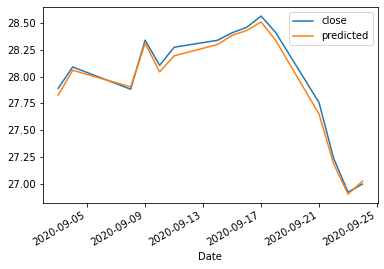

In [19]:
test_symbol = 'EUSC'
test_df = return_predictions_df(test_symbol)
test_df2 = test_df.tail(15)
test_df2.plot()

<AxesSubplot:xlabel='Date'>

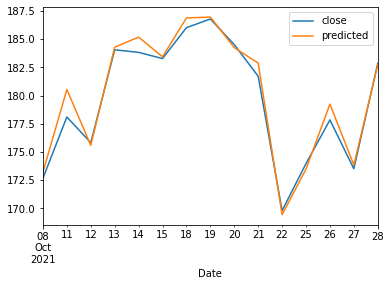

In [20]:
test_symbol = 'GME'
test_df = return_predictions_df(test_symbol)
test_df2 = test_df.tail(15)
graph_ = test_df2.plot()
graph_

In [21]:
## Make nice graphs 